In [1]:
import sys
sys.path.append("../PycharmProjects/line_scraper")

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.datasets import load_breast_cancer
from keras.layers import Input, Dense, Lambda, LSTM, Dropout
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from rl.vae import VAE
from rl.mdn_rnn import MixtureDensity, mdn_loss, generate
from keras.engine.topology import Layer
import math
%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, cuDNN not available)


In [2]:
digit_size = 28

In [3]:

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [4]:
def sort_mnist(x, y):
    y_inds = y.argsort()
    x = x[y_inds[::]]
    y = y[y_inds[::]]
    _, unique_inds = np.unique(y, return_index=True)
    cycles = np.min(np.diff(unique_inds))
    out_x, out_y = [], []
    for i in range(cycles):
        for n in range(10):
            out_x.append(x[unique_inds[n] + i])
            out_y.append(y[unique_inds[n] + i])
    return np.array(out_x), np.array(out_y)

In [5]:
def make_sequence_data(x, y, step=1):
    out_x, out_y = [], []
    for i in range(step, len(x)):
        out_x.append(x[i-step:i])
        out_y.append(y[i])
    return np.array(out_x), np.array(out_y)

In [6]:
sorted_x_train, sorted_y_train = sort_mnist(x_train, y_train)
sorted_x_test,  sorted_y_test  = sort_mnist(x_test, y_test)

In [7]:
sequence_x_train, sequence_y_train = make_sequence_data(sorted_x_train, sorted_y_train)

In [8]:
sequence_x_train[0].shape

(1, 784)

In [9]:
class MDN_RNN:
    def __init__(self, n_components, sequence_length, n_features):
        model = Sequential()
        model.add(LSTM(128, input_shape=(sequence_length, n_features)))
        model.add(Dropout(0.5))
        model.add(MixtureDensity(n_features, n_components))
        self.model = model
        self.model.compile(loss=mdn_loss(numComponents=n_components, outputDim=n_features), optimizer='Adam')

In [10]:
N_LATENT_FACTORS = 10
N_INTERMEDIATE = 256

vae = VAE(x_train.shape[1], N_LATENT_FACTORS, N_INTERMEDIATE)

N_MIXTURE_COMPONENTS = 24
SEQUENCE_LENGTH = 1
N_FEATURES = N_LATENT_FACTORS
mdn_rnn = MDN_RNN(N_MIXTURE_COMPONENTS, SEQUENCE_LENGTH, N_FEATURES)

/home/ben/PycharmProjects/line_scraper/rl/vae.py:47: UserWarning: Output "dense_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_5" during training.
  self.vae.compile(optimizer='rmsprop')
/home/ben/anaconda3/envs/py35/lib/python3.5/site-packages/keras/engine/topology.py:638: UserWarning: Class `rl.mdn_rnn.MixtureDensity` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)


In [11]:
"""
STEP 1
What: Compress the input data spatially
Why : Maximize the ratio of useful information being sent to the Machine Learner
How : Variational auto-encoder parameterizes the input data into a latent vector representing a probability
      distribution of the observed data
      
Cool Things to Note:
vae.vae.fit: Learns the end to end compression algorithm to go from X --> z --> X with minimal information loss
vae.encoder.predict: Creates the latent z vector for given observation
vae.generator.predict: Takes a z vector and recreates the information in the original feature space
"""

vae.vae.fit(x_train,
        shuffle=True,
        epochs=20,
        batch_size=100,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 34us/step - loss: 158.6228 - val_loss: 131.4236
Epoch 2/20
60000/60000 [==============================] - 2s 35us/step - loss: 127.3578 - val_loss: 122.3351
Epoch 3/20
60000/60000 [==============================] - 2s 34us/step - loss: 121.8151 - val_loss: 118.7468
Epoch 4/20
60000/60000 [==============================] - 2s 34us/step - loss: 119.0515 - val_loss: 116.7869
Epoch 5/20
60000/60000 [==============================] - 2s 35us/step - loss: 117.3914 - val_loss: 115.7764
Epoch 6/20
60000/60000 [==============================] - 2s 35us/step - loss: 116.1920 - val_loss: 115.1090
Epoch 7/20
60000/60000 [==============================] - 2s 35us/step - loss: 115.2960 - val_loss: 114.2875
Epoch 8/20
60000/60000 [==============================] - 2s 35us/step - loss: 114.5229 - val_loss: 113.9466
Epoch 9/20
60000/60000 [==============================] - 2s 35us/step - loss:

In [12]:
# Convert the test data to z-vectors to feed to the MDN-RNN
encodings = vae.encoder.predict(sorted_x_test)

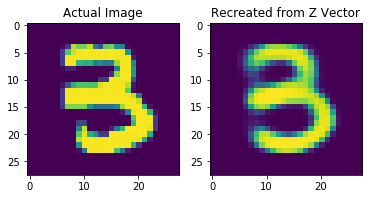

In [13]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(sorted_x_test[3].reshape(digit_size, digit_size))
axarr[1].imshow(vae.generator.predict(encodings[3].reshape(1, 10)).reshape(digit_size, digit_size))
axarr[0].set_title("Actual Image")
axarr[1].set_title("Recreated from Z Vector")

In [14]:
# Take the generated z-vectors and simulate temporal data
sequence_x, sequence_y = make_sequence_data(encodings, encodings, 1)

In [15]:
"""
STEP 2:
What: Compress the data temporally
Why : Allows us to predict the next observation, thus creating a mental model of the world
How : MDN-RNN parameterizes a Gaussian Mixture Model distribution of the latent z-vector representing observation at
      timestep t+1
      
Cool Things to Note:
mdn_rnn.model.fit: Learns to predict a distribution of the next latent z-vector representation of the world from
                   a sequence of the previous compressed world states
generate(mdn_rnn.model.predict): Randomly samples the predicted distribution to create a simulated next observation
                                 in the latent vector space
vae.generator.predict(predicted_z): Converts the predicted next timestep back into the original feature space
"""
mdn_rnn.model.fit(sequence_x[:8000], sequence_y[:8000], shuffle=False, epochs=20, batch_size=100)

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', Prod{axis=(0,), dtype='float32', acc_dtype='float64'}.0, Elemwise{mul,no_inplace}.0, TensorType(float32, matrix), TensorType(float64, matrix), 'local_sum_prod_mul_by_scalar') local_sum_prod_mul_by_scalar
ERROR (theano.gof.opt): Optimization failure due to: local_sum_prod_mul_by_scalar
ERROR (theano.gof.opt): node: Prod{axis=(0,), dtype='float32', acc_dtype='float64'}(Elemwise{mul,no_inplace}.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/py35/lib/python3.5/site-packages/theano/gof/opt.py", line 2022, in process_node
    remove=remove)
  File "/home/ben/anaconda3/envs/py35/lib/python3.5/site-packages/theano/gof/toolbox.py", line 391, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/home/ben/anaconda3/

Epoch 1/20
8000/8000 [==============================] - 0s 58us/step - loss: nan
Epoch 2/20
8000/8000 [==============================] - 0s 58us/step - loss: nan
Epoch 3/20
8000/8000 [==============================] - 0s 57us/step - loss: nan
Epoch 4/20
8000/8000 [==============================] - 0s 58us/step - loss: nan
Epoch 5/20
8000/8000 [==============================] - 0s 58us/step - loss: nan
Epoch 6/20
8000/8000 [==============================] - 0s 59us/step - loss: nan
Epoch 7/20
8000/8000 [==============================] - 0s 58us/step - loss: nan
Epoch 8/20
8000/8000 [==============================] - 0s 58us/step - loss: nan
Epoch 9/20
8000/8000 [==============================] - 0s 58us/step - loss: nan
Epoch 10/20
8000/8000 [==============================] - 0s 58us/step - loss: nan
Epoch 11/20
8000/8000 [==============================] - 0s 59us/step - loss: nan
Epoch 12/20
8000/8000 [==============================] - 0s 58us/step - loss: nan
Epoch 13/20
8000/8000 [==

In [ ]:
z = 

In [20]:
predicted_z = generate(mdn_rnn.model.predict(sequence_x[8000:]), outputDim=10)

In [22]:
predicted_z[0]

array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan]])

In [107]:
gt = vae.generator.predict(sequence_y[8000:])

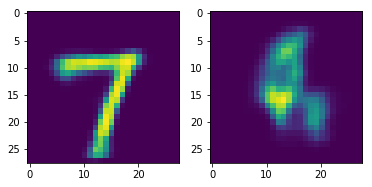

In [113]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(gt[15].reshape(digit_size, digit_size))
axarr[1].imshow(vae.generator.predict(predicted_z[15, :]).reshape(digit_size, digit_size))

In [44]:
batch_size = 100
original_dim = x_train.shape[1]  # Spatial dimension (i.e, # of features)
latent_dim = 4  # Dimension of Z-vector (i.e, 2 reduces to parameterization of Gaussian)
intermediate_dim = 256  # Number of neurons in hidden layer
epochs = 5
epsilon_std = 1.0

# Define the encoding model
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

# The parameters of the latent vector come from the same intermediate layer in the encoding model
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    # Fancy math to transform the unit normal distribution to a parameterized Gaussian
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
# Model to go from latent Z vector back to original spatial dimension
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:41: UserWarning: Output "dense_30" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_30" during training.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 5)            3925        input_11[0][0]                   
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 2)            12          dense_26[0][0]                   
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 2)            12          dense_26[0][0]                   
__________________________________________________________________________________________________
lambda_6 (

(784,)

In [24]:
z_test = encoder.predict(x_test)

In [25]:
decoded = generator.predict(z_test)

In [27]:
_img = decoded[0]

In [30]:
_img.shape

(784,)

In [31]:
digit = _img.reshape(digit_size, digit_size)

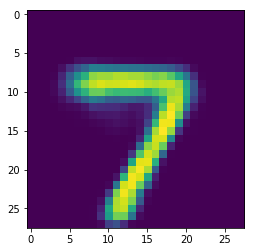

In [33]:
plt.imshow(digit)
plt.show()

In [ ]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

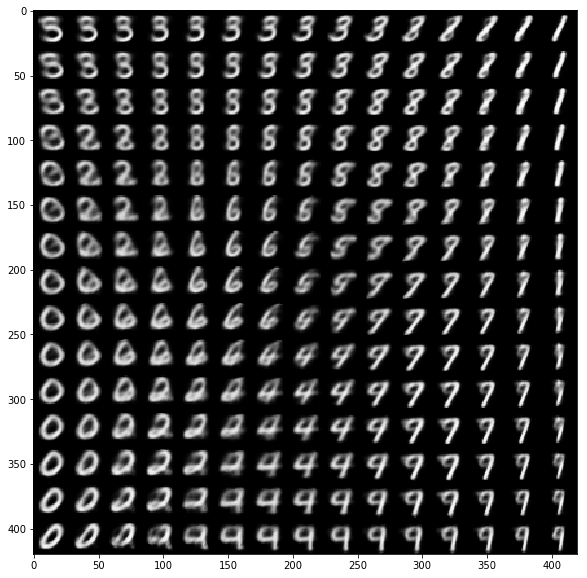

In [8]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits

figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()